## Process data

In [ ]:
from google.colab import drive

drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!tar -xf '/content/gdrive/MyDrive/11777_data/moseas_spanish_mfa.tgz'

In [ ]:
!unzip -l /content/gdrive/MyDrive/11777_data/french_features.zip "*/"

Archive:  /content/gdrive/MyDrive/11777_data/french_features.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2021-10-07 14:23   French/
        0  2021-10-07 05:44   French/French_OpenSmile/
        0  2021-10-07 01:23   French/French_OpenFace/
---------                     -------
        0                     3 files


In [ ]:
!unzip -q /content/gdrive/MyDrive/11777_data/french_features.zip "French/French_OpenFace/*"

In [ ]:
!pip install textgrid

In [ ]:
import numpy as np

In [ ]:
import pandas as pd
original_labels = pd.concat([pd.read_csv("gdrive/MyDrive/moseas_french/batch_1_2/processed_moseas_french_batch_1_2_avglabel.csv"),
                             pd.read_csv("gdrive/MyDrive/moseas_french/batch_3/processed_moseas_french_batch_3_avglabel.csv")
                             ]).reset_index(drop=True)

In [ ]:
import pandas as pd
original_labels = pd.read_csv("gdrive/MyDrive/11-777 MMML/processed_moseas_spanish_batch1_2_avglabel.csv")

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_regression.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [ ]:
train_video_names, test_video_names = set(data[-2]), set(data[-1])

In [ ]:
valid_video_names, test_video_names = set(data[-1][:20]), set(data[-1][20:])

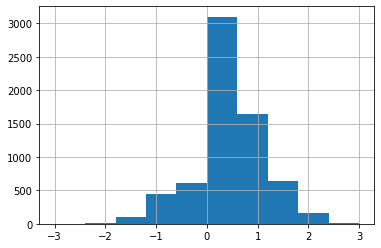

In [ ]:
original_labels[original_labels.apply(lambda x: x["key"][:11] in train_video_names, axis=1)]["sentiment"].hist()

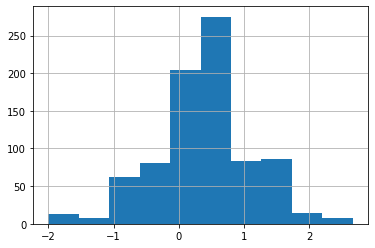

In [ ]:
original_labels[original_labels.apply(lambda x: x["key"][:11] in valid_video_names, axis=1)]["sentiment"].hist()

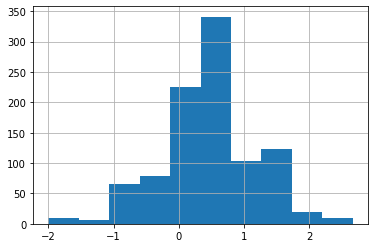

In [ ]:
original_labels[original_labels.apply(lambda x: x["key"][:11] in test_video_names, axis=1)]["sentiment"].hist()

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/data/cz_video_based_data_splits.pickle', 'wb') as handle:
    pickle.dump((set(original_labels[original_labels.apply(lambda x: x["key"][:11] in train_video_names, axis=1)]["key"].values),
                 set(original_labels[original_labels.apply(lambda x: x["key"][:11] in valid_video_names, axis=1)]["key"].values),
                 set(original_labels[original_labels.apply(lambda x: x["key"][:11] in test_video_names, axis=1)]["key"].values)
                 ),
                handle)

In [ ]:
text_lookup = {key: (sentence.strip().split(" "), start, end - start) for _, (key, sentence, start, end)
in original_labels[["key", "sentence", "start", "end"]].iterrows()}

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/data/french_acoustic.pickle', 'rb') as handle:
    ids, feat = pickle.load(handle)

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11777_data/spanish_acoustic.pickle', 'rb') as handle:
    ids, feat = pickle.load(handle)

In [ ]:
speech_map = dict()
for id, speech_feat in zip(ids, feat):
  speech_map[id] = speech_feat

In [ ]:
len(set(speech_map.keys()).intersection(set(original_labels["key"])))

10083

In [ ]:
print([c for c in test.columns if c.startswith(" AU")])

[' AU01_r', ' AU02_r', ' AU04_r', ' AU05_r', ' AU06_r', ' AU07_r', ' AU09_r', ' AU10_r', ' AU12_r', ' AU14_r', ' AU15_r', ' AU17_r', ' AU20_r', ' AU23_r', ' AU25_r', ' AU26_r', ' AU45_r', ' AU01_c', ' AU02_c', ' AU04_c', ' AU05_c', ' AU06_c', ' AU07_c', ' AU09_c', ' AU10_c', ' AU12_c', ' AU14_c', ' AU15_c', ' AU17_c', ' AU20_c', ' AU23_c', ' AU25_c', ' AU26_c', ' AU28_c', ' AU45_c']


In [ ]:
import os
import numpy as np
from tqdm import tqdm
from textgrid import TextGrid

face_feat_dim_names = [' AU01_r', ' AU02_r', ' AU04_r', ' AU05_r', ' AU06_r', ' AU07_r', ' AU09_r', ' AU10_r', ' AU12_r', ' AU14_r', ' AU15_r', ' AU17_r', ' AU20_r', ' AU23_r', ' AU25_r', ' AU26_r', ' AU45_r', ' AU01_c', ' AU02_c', ' AU04_c', ' AU05_c', ' AU06_c', ' AU07_c', ' AU09_c', ' AU10_c', ' AU12_c', ' AU14_c', ' AU15_c', ' AU17_c', ' AU20_c', ' AU23_c', ' AU25_c', ' AU26_c', ' AU28_c', ' AU45_c']

def align_openface(alignment_dir):

  ids = list()
  features = list()

  unmatched_videos = 0

  for video_name in tqdm(os.listdir(alignment_dir), desc="align"):
    try:
      openface_feats = pd.read_csv(f"/content/French/French_OpenFace/{video_name}.csv")
    except:
      unmatched_videos += 1
      continue

    for segment_alignment in os.listdir(alignment_dir + "/" + video_name):
      if segment_alignment[0] == ".":
        continue
      key_end_idx = 12 + segment_alignment[12:].find("_")
      key = segment_alignment[:key_end_idx]

      if key not in text_lookup:
        continue

      ids.append(key)

      segment_feats = list()

      word_alignment = TextGrid.fromFile(f"{alignment_dir}/{video_name}/{segment_alignment}")[0]
      sentence, start, length = text_lookup[key]

      for word in word_alignment:
        if word.mark != "":
          if word.maxTime - word.minTime < 0.04:
            word.maxTime += 0.04
          relevant_feats = openface_feats[(start + word.minTime <= openface_feats[" timestamp"]) & (openface_feats[" timestamp"] <= start + word.maxTime)][face_feat_dim_names].values
          segment_feats.append(relevant_feats.mean(axis=0))
      features.append(np.stack(segment_feats))

  print(f"{unmatched_videos} videos do not have openFace!")
  return ids, features

In [ ]:
aligned_ids, aligned_features = align_openface("/content/french_alignment")

align: 100%|██████████| 315/315 [03:04<00:00,  1.71it/s]

183 videos do not have openFace!


In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/data/french_mfa_aligned_openface.pickle', 'wb') as handle:
    pickle.dump((aligned_ids, aligned_features), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import numpy as np
from tqdm import tqdm
import os

openface_feats = list()
openface_keys = list()

root = "/content/gdrive/MyDrive/11-777 MMML/process_visual_features/"
for filename in tqdm(os.listdir(root), desc="read"):
  if not filename.startswith("Spanish"):
    continue

  data = np.load(root + "/" + filename, allow_pickle=True)
  openface_feats.extend(data["features"])
  openface_keys.extend(data["key"])

read: 100%|██████████| 22/22 [01:11<00:00,  3.23s/it]


In [ ]:
openface_lookup = {k:v for k, v in zip(openface_keys, openface_feats)}

In [ ]:
openface_feats[200].shape

(53, 713)

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from textgrid import TextGrid

def align_openface_shuhao(alignment_dir):

  ids = list()
  features = list()

  unmatched_videos = 0
  problematic_videos = 0

  for video_name in tqdm(os.listdir(alignment_dir), desc="align"):
    for segment_alignment in os.listdir(alignment_dir + "/" + video_name):
      if segment_alignment[0] == ".":
        continue
      key_end_idx = 12 + segment_alignment[12:].find("_")
      key = segment_alignment[:key_end_idx]

      if key not in text_lookup or key not in openface_lookup:
        unmatched_videos += 1
        continue

      segment_feats = list()

      openface_feats = openface_lookup[key]
      word_alignment = TextGrid.fromFile(f"{alignment_dir}/{video_name}/{segment_alignment}")[0]
      sentence, start, length = text_lookup[key]

      openface_interval = openface_feats.shape[0] / length

      if openface_interval < 8:
        problematic_videos += 1
        continue

      ids.append(key)

      for word in word_alignment:
        if word.mark != "":
          relevant_feats = openface_feats[int(word.minTime * openface_interval): int(word.maxTime * openface_interval) + 1, :]
          segment_feats.append(relevant_feats.mean(axis=0))
      features.append(np.stack(segment_feats))

  print(f"{unmatched_videos} videos do not have openFace and {problematic_videos} videos have problems!")
  return ids, features

In [ ]:
aligned_ids, aligned_features = align_openface_shuhao("/content/spanish_alignment")

align: 100%|██████████| 264/264 [00:20<00:00, 12.95it/s]

2243 videos do not have openFace and 272 videos have problems!


In [ ]:
len(aligned_ids)

4588

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/data/spanish_mfa_aligned_openface_shuhao_full.pickle', 'wb') as handle:
    pickle.dump((aligned_ids, aligned_features), handle)

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from textgrid import TextGrid

def align_speech(alignment_dir):

  ids = list()
  features = list()

  unmatched_videos = 0

  for video_name in tqdm(os.listdir(alignment_dir), desc="align"):
    for segment_alignment in os.listdir(alignment_dir + "/" + video_name):
      if segment_alignment[0] == ".":
        continue
      key_end_idx = 12 + segment_alignment[12:].find("_")
      key = segment_alignment[:key_end_idx]

      if key not in text_lookup:
        unmatched_videos += 1
        continue

      ids.append(key)

      segment_feats = list()

      if key not in speech_map:
        unmatched_videos += 1
        continue

      speech_feats = speech_map[key]
      word_alignment = TextGrid.fromFile(f"{alignment_dir}/{video_name}/{segment_alignment}")[0]
      sentence, start, length = text_lookup[key]

      librosa_interval = speech_feats.shape[1] / length

      for word in word_alignment:
        if word.mark != "":
          relevant_feats = speech_feats.T[int(word.minTime * librosa_interval): int(word.maxTime * librosa_interval) + 1, :]
          segment_feats.append(relevant_feats.mean(axis=0))
      features.append(np.stack(segment_feats))
  print(f"{unmatched_videos} segments do not have speech!")
  return ids, features

In [ ]:
aligned_ids, aligned_features = align_speech("/content/spanish_alignment")

align: 100%|██████████| 264/264 [00:31<00:00,  8.44it/s]

0 segments do not have speech!


In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/data/spanish_mfa_aligned_librosa_acoustic_full.pickle', 'wb') as handle:
    pickle.dump((aligned_ids, aligned_features), handle)

In [ ]:
aligned_features[30].shape

(18, 25)

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/data/french_mfa_aligned_openface.pickle', 'rb') as handle:
    aligned_openface_ids, aligned_openface_feats = pickle.load(handle)

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/data/es_word_glove.pickle', 'rb') as handle:
  word_embeddings = pickle.load(handle)

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from textgrid import TextGrid

def get_word_feats(alignment_dir):

  ids = list()
  features = list()

  unk_words = 0

  for video_name in tqdm(os.listdir(alignment_dir), desc="align"):
    
    for segment_alignment in os.listdir(alignment_dir + "/" + video_name):
      if segment_alignment[0] == ".":
        continue
      key_end_idx = 12 + segment_alignment[12:].find("_")
      key = segment_alignment[:key_end_idx]

      if key not in text_lookup:
        continue

      ids.append(key)

      segment_feats = list()
      word_alignment = TextGrid.fromFile(f"{alignment_dir}/{video_name}/{segment_alignment}")[0]

      for word in word_alignment:
        if word.mark != "":
          if word.mark in word_embeddings:
            relevant_feats = word_embeddings[word.mark]
          else:
            relevant_feats = np.zeros(300)
            unk_words += 1
          segment_feats.append(relevant_feats)
      features.append(np.stack(segment_feats))

  print(f"{unk_words} words are not matched")
  return ids, features

In [ ]:
aligned_ids, aligned_features = get_word_feats("/content/spanish_alignment")

align: 100%|██████████| 264/264 [00:23<00:00, 11.25it/s]

4162 words are not matched


In [ ]:
import pickle

with open('/content/gdrive/MyDrive/11-777 MMML/data/spanish_mfa_aligned_word_embed.pickle', 'wb') as handle:
    pickle.dump((aligned_ids, aligned_features), handle, protocol=pickle.HIGHEST_PROTOCOL)